In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import csv
import cv2
import numpy as np
import pandas as pd
import plotly.express as ex
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from PIL import Image
import torch
import random
from torchvision import transforms
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-05 10:14:29.008655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 10:14:29.008781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 10:14:29.275148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_train=pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
df_test=pd.read_csv("/kaggle/input/aptos2019-blindness-detection/test.csv")

In [4]:
df_train.tail(10)

,id_code,diagnosis
3652,ff52392372d3,2
3653,ff59d44a70a7,0
3654,ff631653374e,0
3655,ff77e8e5b5f3,2
3656,ff8a0b45c789,4
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0
3661,ffec9a18a3ce,2


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [6]:
df_train['diagnosis'].unique()

array([2, 4, 1, 0, 3])

In [7]:
df_train.isna().value_counts()

id_code  diagnosis
False    False        3662
Name: count, dtype: int64

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id_code  1928 non-null   object
dtypes: object(1)
memory usage: 15.2+ KB


In [9]:
df_test.head(5)

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [10]:
ex.pie(df_train,names='diagnosis',hole=0.4)

array([[<Axes: title={'center': 'diagnosis'}>]], dtype=object)

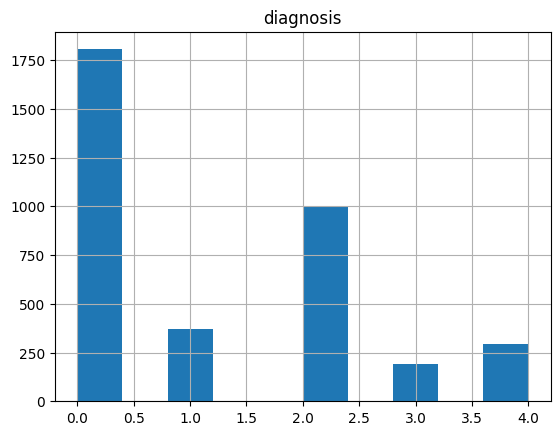

In [11]:
df_train.hist()

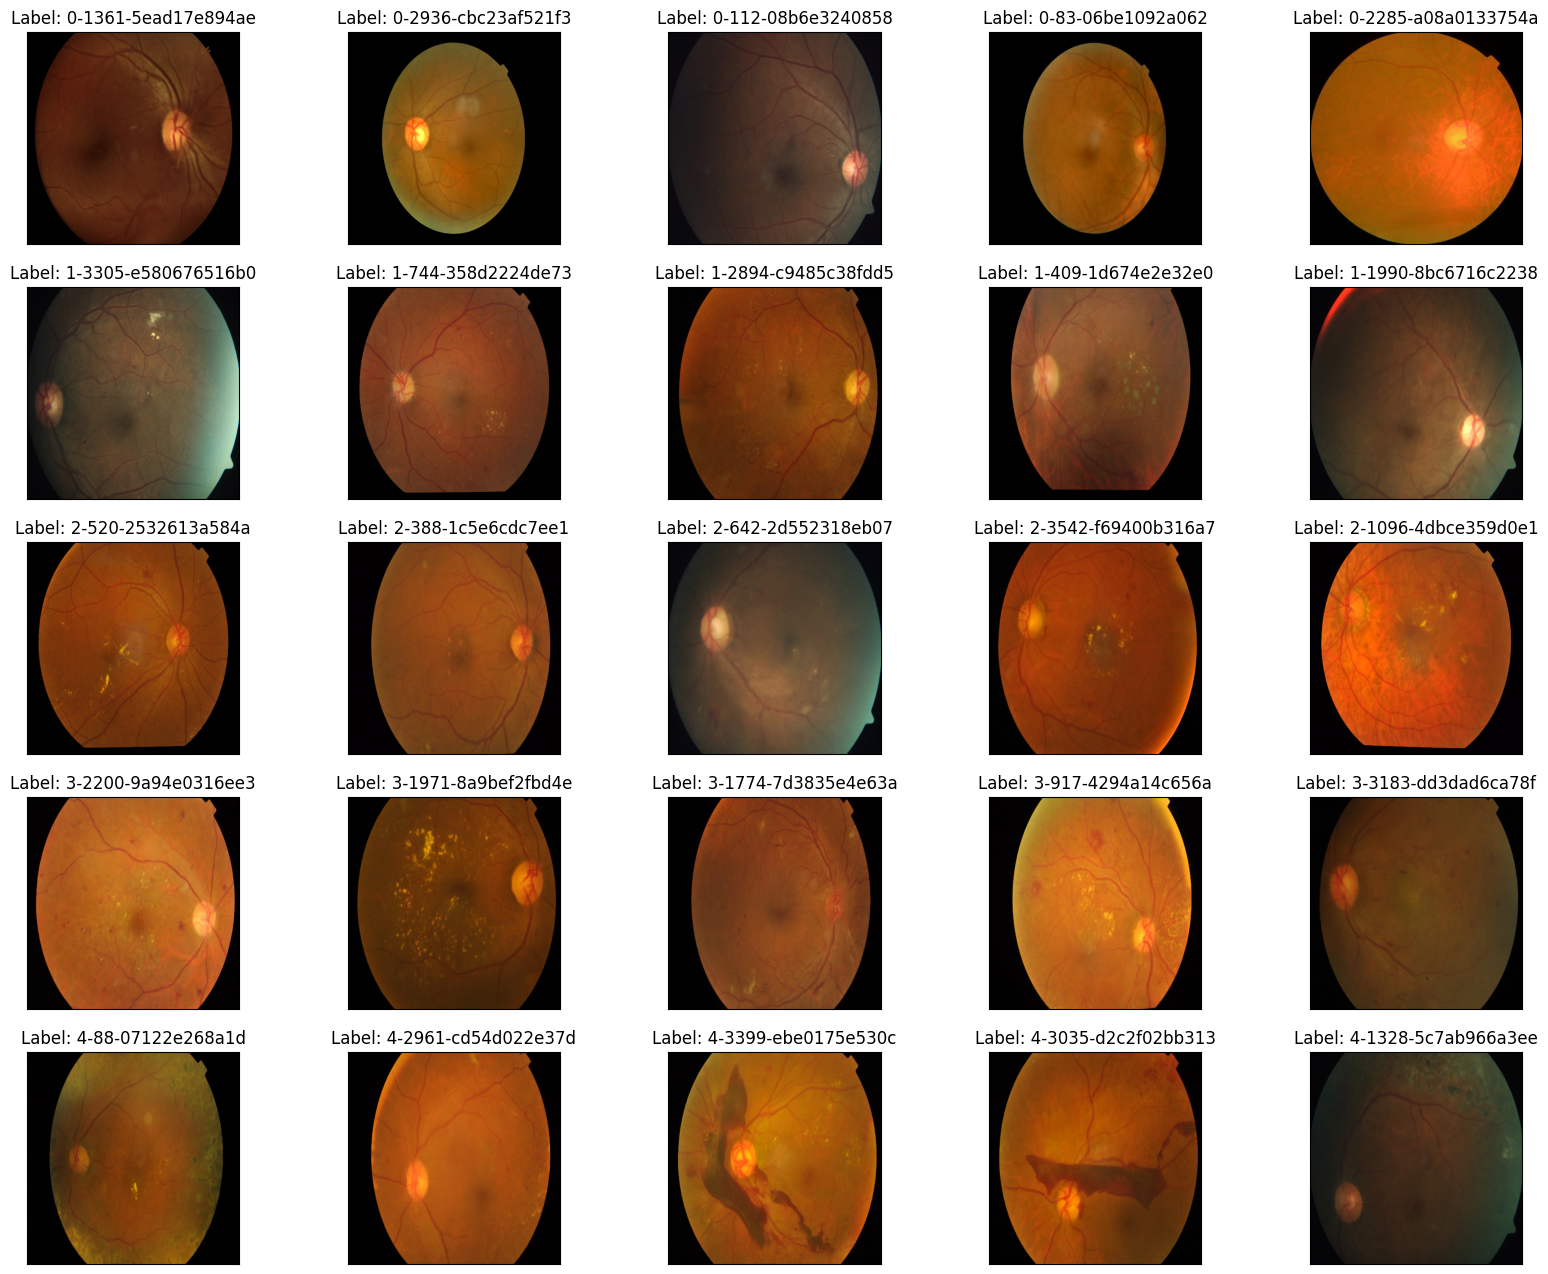

In [12]:
fig = plt.figure(figsize=(20, 16))
for class_id in sorted(df_train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=77).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
        

In [13]:
folder_path="/kaggle/input/aptos2019-blindness-detection/train_images"


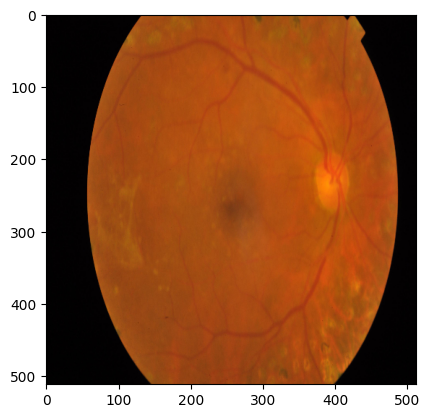

In [14]:
img=cv2.imread(os.path.join(folder_path,df_train["id_code"][1]+".png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(512,512))
plt.imshow(img)

In [15]:
train_img=[]
y_class=[]
transform = transforms.Compose([transforms.ToTensor()])
for i in range(3662):
    img=cv2.imread(os.path.join(folder_path,df_train["id_code"][i]+".png"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(512,512))
    train_img.append(img)
    y_class.append(int(df_train["diagnosis"][i]))   

In [16]:
test_img=[]
for i in range(1928):
    img=cv2.imread(os.path.join("/kaggle/input/aptos2019-blindness-detection/test_images",df_test["id_code"][i]+".png"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(512,512))
    test_img.append(img)

In [17]:
train_img=np.array(train_img)

In [18]:

train_img=torch.from_numpy(train_img)

In [19]:
train_img.shape

torch.Size([3662, 512, 512, 3])

In [20]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', sparse=False)
y_class=np.array(y_class)
y_class=y_class.reshape(-1,1)
y_train=encoder.fit_transform(y_class)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [21]:
y_train=torch.from_numpy(y_train)

In [22]:
model = Sequential()

# First convolutional layer
model.add(Convolution2D(32,strides = (4, 4), activation='relu',padding='valid', input_shape=(512,512,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,padding='valid'))
model.add(Dropout(0.25))

# Second convolutional layer
model.add(Convolution2D(64, 11,strides = (1, 1), activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,padding='valid'))
model.add(Dropout(0.25))

# Third convolutional layer
model.add(Convolution2D(128, 3,strides = (1, 1), activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,padding='valid'))
model.add(Dropout(0.25))

# Fourth convolutional layer
model.add(Convolution2D(256, 3,strides = (1, 1), activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,padding='valid'))
model.add(Dropout(0.25))

# Fifth convolutional layer
model.add(Convolution2D(512, 3,strides = (1, 1), activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,padding='valid'))
model.add(Dropout(0.25))

# Flatten the output and add a dense layer
model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.002)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax',kernel_regularizer=l2(0.002)))

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 53, 53, 64)     │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,077,893 (7.93 MB)

 Trainable params: 2,075,909 (7.92 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [1]:
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate

2024-05-06 17:42:57.286815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 17:42:57.286927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 17:42:57.464585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image/__init__.py)

In [23]:
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    loss_weights=None,
    metrics=['accuracy'],
    weighted_metrics=None,
    run_eagerly=False,
    steps_per_execution=1,
    jit_compile="auto",
    auto_scale_loss=True,
)

In [24]:
history = model.fit(
    train_img,
    y_train,
    batch_size = 32,
    epochs = 100,
    validation_split = 0.2,
    shuffle = True
)

Epoch 1/100
 3/92 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3177 - loss: 4.0529 

I0000 00:00:1714904786.877985     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714904786.903712     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5339 - loss: 2.6421

W0000 00:00:1714904815.246067     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 360ms/step - accuracy: 0.5344 - loss: 2.6384 - val_accuracy: 0.6876 - val_loss: 1.9385
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6551 - loss: 1.9385 - val_accuracy: 0.6685 - val_loss: 1.6916
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6868 - loss: 1.6800 - val_accuracy: 0.7312 - val_loss: 1.5360
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6883 - loss: 1.5360 - val_accuracy: 0.7326 - val_loss: 1.3800
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6993 - loss: 1.4030 - val_accuracy: 0.6630 - val_loss: 1.3919
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7080 - loss: 1.2897 - val_accuracy: 0.7353 - val_loss: 1.2051
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7175 - loss: 1.1923 - val_accuracy: 0.7326 - val_loss: 1.1096
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7287 - loss: 1.0931 - val_accuracy: 0.7312 - val

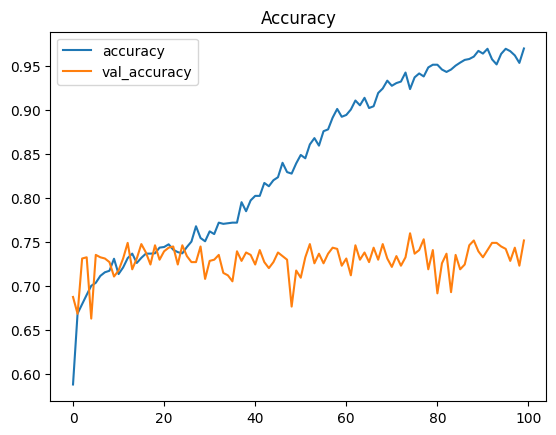

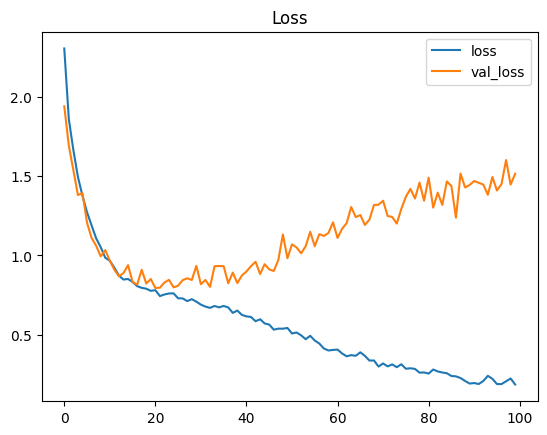

In [25]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
test_img=np.array(test_img)
test_img=torch.from_numpy(test_img)
val = model.predict(test_img)


13/61 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

W0000 00:00:1714905233.530607     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


In [27]:
model.save('/kaggle/working/diabeticretinopathy.h5')

In [30]:
val=val.reshape(-1,1)

In [31]:
val

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [0]])

In [32]:

df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/sample_submission.csv')
df['Class'] = val
df.to_csv('/kaggle/working/submission.csv', index=False)